In [45]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
import math


# Import modules containing classes and functions needed for the simulation
from src.model_ctrl import RenG, gain
from src.model_sys import TrackingRobot, DynamicObstacle
from src.plots import plot_traj_vs_time, plot_trajectories_tracking_dyn_obs
from src.loss_functions import f_loss_u, f_loss_obst_dyn_tracking, f_loss_states_tracking 
from src.utils import set_params_tracking
from src.model_trk import ReferenceTrajectory, dlqr

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Ts = 0.05
b1 = 2
b2 = 0.5
A_np = np.array([[1, 0, Ts, 0],
                 [0, 1, 0, Ts],
                 [0, 0, 1 - Ts*b1, 0],
                 [0, 0, 0, 1 - Ts*b1]], dtype=np.float32)
B_np = np.array([[0, 0],
                 [0, 0],
                 [Ts, 0],
                 [0, Ts]], dtype=np.float32)
N = 310  # horizon length
T = np.linspace(0, N*Ts, N+1)
r = 3.0  # radius of semicircle
theta_ref = np.linspace(0, 2*math.pi, N+1)

# Desired semicircular positions
p_ref_des = np.vstack((r * np.cos(theta_ref), r * np.sin(theta_ref)))  # shape (2, N+1)
# Use finite differences to approximate velocity
dp_ref_des = np.gradient(p_ref_des, Ts, axis=1)
x_ref_des_np = np.vstack((p_ref_des, dp_ref_des)).T  # shape (N+1, 4)

# Convert to torch tensor
x_ref_des = torch.tensor(x_ref_des_np, dtype=torch.float32, device=device)

# Initial state (start at beginning of semicircle)
x0t = x_ref_des[0]
x_traj_opt_np = np.load("trained_models/opt_traj_300_r3.npy")

# 3. Create a ReferenceTrajectory instance
ref_traj = ReferenceTrajectory(x_traj_opt_np, 1)

# 4. LQR Design for Tracking (using linearized error dynamics)
# Define matrices A and B (same as MATLAB)
# LQR weights (as in MATLAB code)
Q = 0.5 * np.eye(4, dtype=np.float32)
R = 0.05 * np.eye(2, dtype=np.float32)
K = dlqr(A_np, B_np, Q, R)  # returns torch tensor

# Convert A and B to torch tensors
A_t = torch.tensor(A_np, dtype=torch.float32, device=device)
B_t = torch.tensor(B_np, dtype=torch.float32, device=device)

# 5. Create ClosedLoopSystem instance
###########################################
# Define the system model
syst = TrackingRobot(A_t, B_t, K, Ts, b2, device=device)
gainF = 1
# Set the random seed for reproducibility
torch.manual_seed(10)
# Set the parameters and hyperparameters for the simulation
params = set_params_tracking()
min_dist, t_end, n_agents, learning_rate, epochs, Q, alpha_u, alpha_ca, alpha_obst, n_xi, \
l, n_traj, std_ini, gamma_bar, wmax, decayw,maxtimew = params
sim_time = t_end

In [46]:
###########################################
# Define the controller model
ctl = RenG(syst.n, syst.m, n_xi, l, bias=False, mode="l2stable", gamma=1)
amplifier = gain(gamma_bar)

ctl.load_state_dict(torch.load("trained_models/offline_obstacles_ctl.pt", weights_only=False))
ctl.set_param()
amplifier.load_state_dict(torch.load("trained_models/offline_obstacles_amp.pt", weights_only=False))

# Define the optimizer and its parameters
optimizer = torch.optim.Adam([
                {'params': ctl.parameters()},
                {'params': amplifier.parameters(), 'lr': 1e-1}], lr=learning_rate)

In [47]:
gamma_bar = amplifier.gamma.detach()
time = torch.linspace(0, sim_time, sim_time+1)
x0 = torch.tensor([3,0.0,0,0])
x0t = x_ref_des[0]
w_std = 0.03 #3
w_obs = 0.01#2
# Amplitude frequency and initial position obstacles
Aobs = 1.2
fobs = 1/20
init_pos1 = 3.0
init_pos2 = -3.0

velocity_noiseCL = np.random.uniform(-w_obs, w_obs,t_end + 1)
w_inCL = w_std * torch.randn((t_end + 1, syst.n))

------- Print CL trajectories offline controller --------


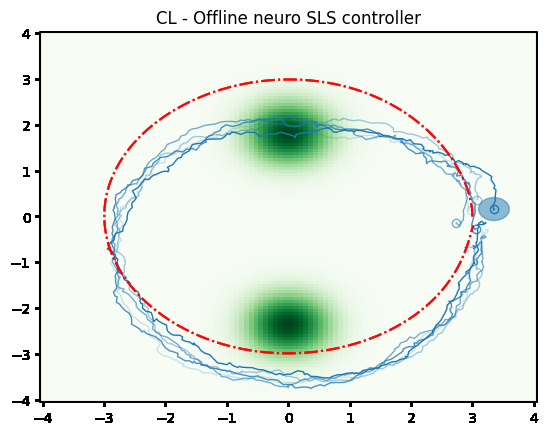

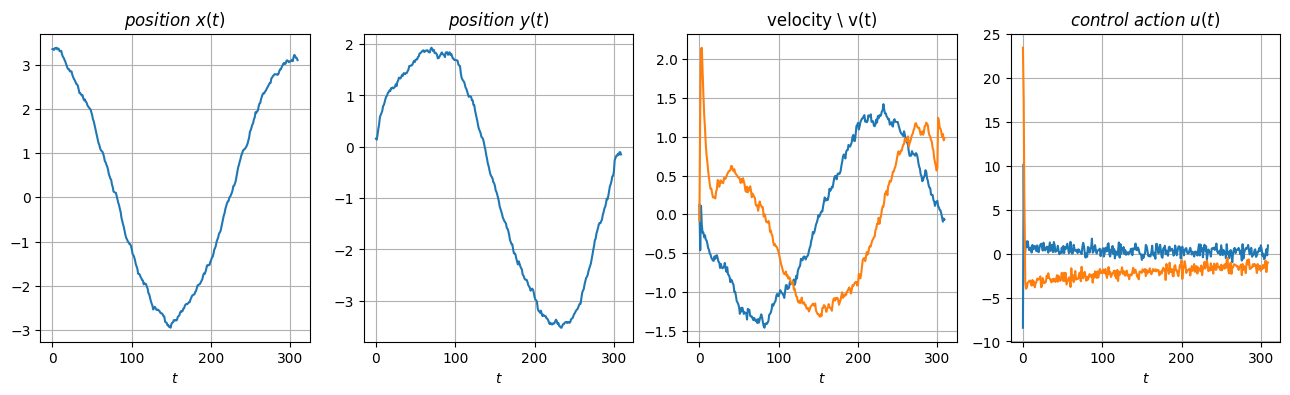

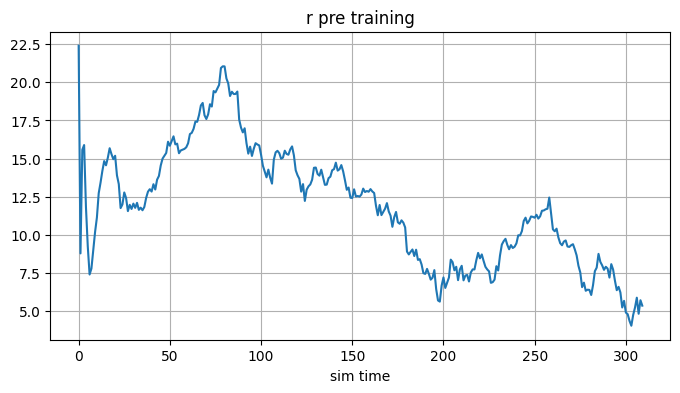

In [48]:
# Plot and log the open-loop trajectories before training
print("------- Print CL trajectories offline controller --------")
r_log_pre = torch.zeros(sim_time, 1)
x_log_pre = torch.zeros((t_end, syst.n, n_traj))
u_log_pre = torch.zeros((t_end, syst.m, n_traj))
with torch.no_grad():
    for traj in range(n_traj):
        loss = 0
        dynamic_obstacle = DynamicObstacle(amplitude=Aobs, frequency=fobs, init_pos = init_pos1, phase=torch.randn(1).item(), noise_level=w_obs, device=device)
        dynamic_obstacle2 = DynamicObstacle(amplitude=Aobs, frequency=-fobs, init_pos = init_pos2, phase=torch.randn(1).item(), noise_level=w_obs, device=device)
        devx0 = std_ini * torch.randn(x0.shape)
        w_in = w_std * torch.randn((t_end + 1, syst.n))
        x = x0 + devx0
        x_error = x - x0t  # start 
        xi = torch.zeros(ctl.n)
        w_REN = x_error
        u, xi = ctl(0, w_REN, xi)
        usys = amplifier(u)
        for t in range(t_end):
            if traj == 0:
                eps_pre = torch.norm(x_error)
                r_log_pre[t,:] = eps_pre.detach()*gainF*(gamma_bar+1)
            obstacle_pos1 = dynamic_obstacle.update_position(dt=Ts)
            obstacle_pos2 = dynamic_obstacle2.update_position(dt=Ts)
            obstacle_pos = torch.cat((obstacle_pos1,obstacle_pos2),dim=0)
            x = x_error + torch.tensor(ref_traj.get_reference(t), dtype=torch.float32, device=device)
            x_log_pre[t, :,traj] = (x_error+torch.tensor(ref_traj.get_reference(t))).detach()
            u_log_pre[t, :,traj] = usys.detach()
            w_syst = w_in[t,:]
            x_error = syst.forward(t, x_error, usys, w_syst)
            w_REN = w_syst 
            u, xi = ctl(t, w_REN, xi)
            usys = amplifier(u)
    

plot_trajectories_tracking_dyn_obs(x_log_pre, x_traj_opt_np, syst.n_agents,obstacle_pos, text="CL - Offline neuro SLS controller", T=t_end, obst=alpha_obst)
plot_traj_vs_time(t_end, syst.n_agents, x_log_pre[:,:,0], u_log_pre[:,:,0])

plt.figure(figsize=(4 * 2, 4))
plt.plot(time[:-1], r_log_pre[:,:].detach())
plt.xlabel(r'sim time')
plt.title(r'r pre training')
plt.grid()
plt.show()

------------ Begin training ------------
Problem: RH neurSLS -- t_end: 310 -- lr: 1.00e-03 -- epochs: 150 -- n_traj: 3 -- std_ini: 0.20
 -- alpha_u: 0.1 -- alpha_ca: 100 -- alpha_obst: 1.0e+03
REN info -- n_xi: 8 -- l: 8
RH info -- Horizon: 20
--------- --------- ---------  ---------
Simulation time: 0  ---  |x-xbar|: 0.225911


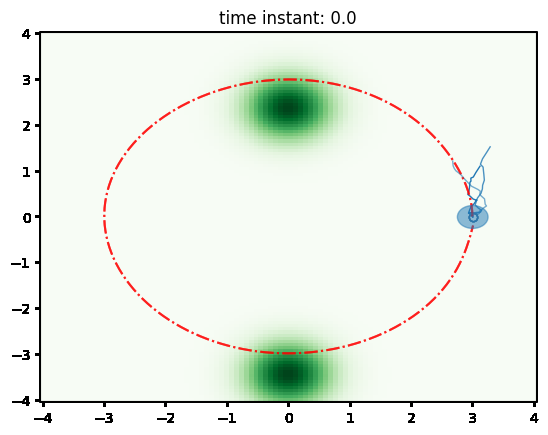

Simulation time: 2  ---  |x-xbar|: 0.450159
Simulation time: 4  ---  |x-xbar|: 0.756549
Simulation time: 6  ---  |x-xbar|: 0.670158
Simulation time: 8  ---  |x-xbar|: 0.389012
Simulation time: 10  ---  |x-xbar|: 0.483346
Simulation time: 12  ---  |x-xbar|: 0.744073
Simulation time: 14  ---  |x-xbar|: 0.528755
Simulation time: 16  ---  |x-xbar|: 0.642821
Simulation time: 18  ---  |x-xbar|: 0.290353
Simulation time: 20  ---  |x-xbar|: 0.330395
Simulation time: 22  ---  |x-xbar|: 0.642802
Simulation time: 24  ---  |x-xbar|: 1.405783
Simulation time: 26  ---  |x-xbar|: 0.981841
Simulation time: 28  ---  |x-xbar|: 0.579602
Simulation time: 30  ---  |x-xbar|: 0.376608
Simulation time: 32  ---  |x-xbar|: 0.547191
Simulation time: 34  ---  |x-xbar|: 0.898481
Simulation time: 36  ---  |x-xbar|: 1.183159
Simulation time: 38  ---  |x-xbar|: 1.244667
Simulation time: 40  ---  |x-xbar|: 1.162796
Simulation time: 42  ---  |x-xbar|: 1.088589
Simulation time: 44  ---  |x-xbar|: 0.789800
Simulation tim

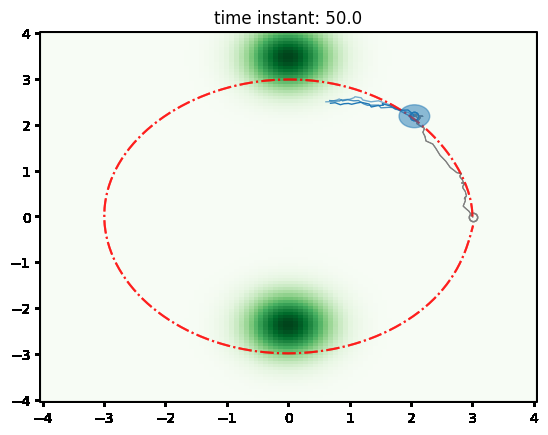

Simulation time: 52  ---  |x-xbar|: 0.831729
Simulation time: 54  ---  |x-xbar|: 0.886767
Simulation time: 56  ---  |x-xbar|: 1.038353
Simulation time: 58  ---  |x-xbar|: 0.985709
Simulation time: 60  ---  |x-xbar|: 1.008069
Simulation time: 62  ---  |x-xbar|: 1.203140
Simulation time: 64  ---  |x-xbar|: 1.143146
Simulation time: 66  ---  |x-xbar|: 1.091130
Simulation time: 68  ---  |x-xbar|: 1.310435
Simulation time: 70  ---  |x-xbar|: 1.190863
Simulation time: 72  ---  |x-xbar|: 1.435930
Simulation time: 74  ---  |x-xbar|: 1.412805
Simulation time: 76  ---  |x-xbar|: 1.466118
Simulation time: 78  ---  |x-xbar|: 1.481173
Simulation time: 80  ---  |x-xbar|: 1.433038
Simulation time: 82  ---  |x-xbar|: 1.466724
Simulation time: 84  ---  |x-xbar|: 1.550642
Simulation time: 86  ---  |x-xbar|: 1.142633
Simulation time: 88  ---  |x-xbar|: 0.767920
Simulation time: 90  ---  |x-xbar|: 0.460189
Simulation time: 92  ---  |x-xbar|: 0.491748
Simulation time: 94  ---  |x-xbar|: 0.517789
Simulation

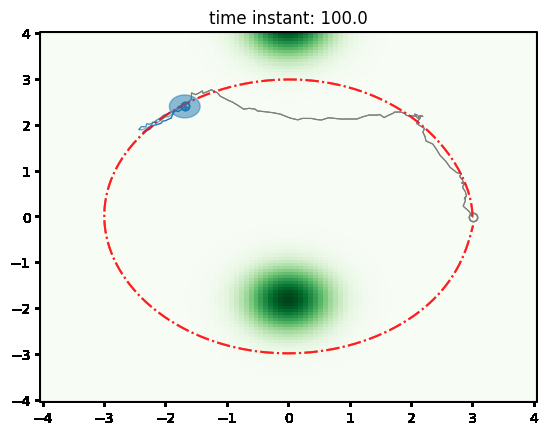

Simulation time: 102  ---  |x-xbar|: 0.786380
Simulation time: 104  ---  |x-xbar|: 0.290648
Simulation time: 106  ---  |x-xbar|: 0.447257
Simulation time: 108  ---  |x-xbar|: 0.583536
Simulation time: 110  ---  |x-xbar|: 1.151018
Simulation time: 112  ---  |x-xbar|: 0.935523
Simulation time: 114  ---  |x-xbar|: 0.834510
Simulation time: 116  ---  |x-xbar|: 0.695893
Simulation time: 118  ---  |x-xbar|: 0.553014
Simulation time: 120  ---  |x-xbar|: 0.819106
Simulation time: 122  ---  |x-xbar|: 0.440129
Simulation time: 124  ---  |x-xbar|: 0.550949
Simulation time: 126  ---  |x-xbar|: 0.409002
Simulation time: 128  ---  |x-xbar|: 0.271505
Simulation time: 130  ---  |x-xbar|: 0.306352
Simulation time: 132  ---  |x-xbar|: 0.346074
Simulation time: 134  ---  |x-xbar|: 0.585155
Simulation time: 136  ---  |x-xbar|: 1.001676
Simulation time: 138  ---  |x-xbar|: 0.479903
Simulation time: 140  ---  |x-xbar|: 0.212965
Simulation time: 142  ---  |x-xbar|: 0.243930
Simulation time: 144  ---  |x-xbar

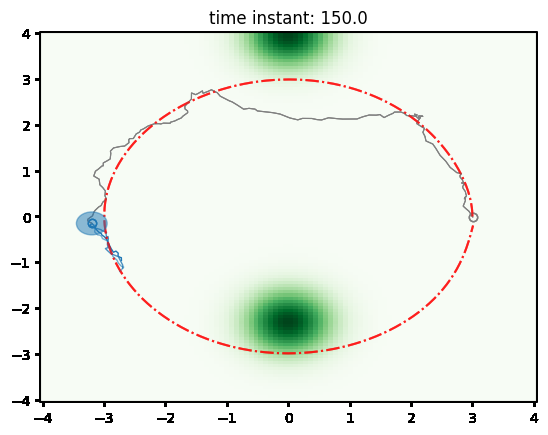

Simulation time: 152  ---  |x-xbar|: 0.416423
Simulation time: 154  ---  |x-xbar|: 0.365095
Simulation time: 156  ---  |x-xbar|: 0.294186
Simulation time: 158  ---  |x-xbar|: 0.358437
Simulation time: 160  ---  |x-xbar|: 0.288720
Simulation time: 162  ---  |x-xbar|: 0.376631
Simulation time: 164  ---  |x-xbar|: 0.753990
Simulation time: 166  ---  |x-xbar|: 0.497314
Simulation time: 168  ---  |x-xbar|: 0.461320
Simulation time: 170  ---  |x-xbar|: 0.399359
Simulation time: 172  ---  |x-xbar|: 0.476731
Simulation time: 174  ---  |x-xbar|: 0.306548
Simulation time: 176  ---  |x-xbar|: 0.485637
Simulation time: 178  ---  |x-xbar|: 0.328513
Simulation time: 180  ---  |x-xbar|: 0.308353
Simulation time: 182  ---  |x-xbar|: 0.395704
Simulation time: 184  ---  |x-xbar|: 0.228431
Simulation time: 186  ---  |x-xbar|: 0.300376
Simulation time: 188  ---  |x-xbar|: 0.432543
Simulation time: 190  ---  |x-xbar|: 0.308833
Simulation time: 192  ---  |x-xbar|: 0.370996
Simulation time: 194  ---  |x-xbar

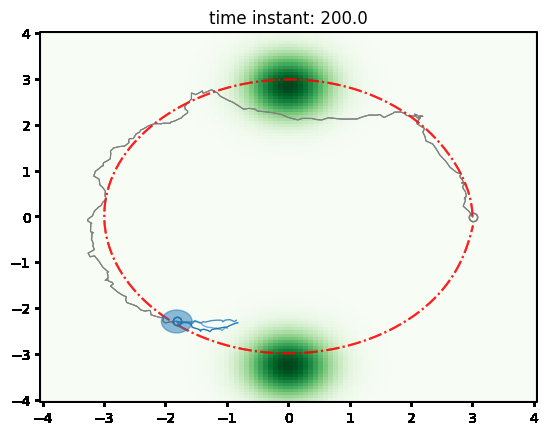

Simulation time: 202  ---  |x-xbar|: 0.723447
Simulation time: 204  ---  |x-xbar|: 0.875390
Simulation time: 206  ---  |x-xbar|: 1.106998
Simulation time: 208  ---  |x-xbar|: 1.071047
Simulation time: 210  ---  |x-xbar|: 1.159157
Simulation time: 212  ---  |x-xbar|: 1.244824
Simulation time: 214  ---  |x-xbar|: 1.211912
Simulation time: 216  ---  |x-xbar|: 1.205794
Simulation time: 218  ---  |x-xbar|: 1.322061
Simulation time: 220  ---  |x-xbar|: 1.319840
Simulation time: 222  ---  |x-xbar|: 1.319303
Simulation time: 224  ---  |x-xbar|: 1.336541
Simulation time: 226  ---  |x-xbar|: 1.454847
Simulation time: 228  ---  |x-xbar|: 1.476420
Simulation time: 230  ---  |x-xbar|: 1.339471
Simulation time: 232  ---  |x-xbar|: 1.289935
Simulation time: 234  ---  |x-xbar|: 1.154726
Simulation time: 236  ---  |x-xbar|: 0.869593
Simulation time: 238  ---  |x-xbar|: 0.688628
Simulation time: 240  ---  |x-xbar|: 0.539265
Simulation time: 242  ---  |x-xbar|: 0.626292
Simulation time: 244  ---  |x-xbar

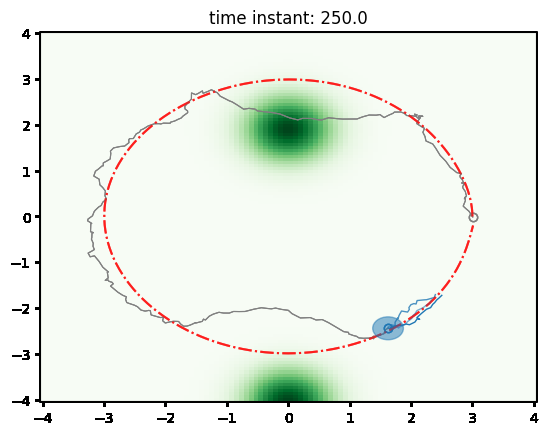

Simulation time: 252  ---  |x-xbar|: 0.365566
Simulation time: 254  ---  |x-xbar|: 0.311223
Simulation time: 256  ---  |x-xbar|: 0.252688
Simulation time: 258  ---  |x-xbar|: 0.316382
Simulation time: 260  ---  |x-xbar|: 0.233012
Simulation time: 262  ---  |x-xbar|: 0.248433
Simulation time: 264  ---  |x-xbar|: 0.171858
Simulation time: 266  ---  |x-xbar|: 0.216320
Simulation time: 268  ---  |x-xbar|: 0.455087
Simulation time: 270  ---  |x-xbar|: 0.166678
Simulation time: 272  ---  |x-xbar|: 0.351398
Simulation time: 274  ---  |x-xbar|: 0.191483
Simulation time: 276  ---  |x-xbar|: 0.394013
Simulation time: 278  ---  |x-xbar|: 0.216136
Simulation time: 280  ---  |x-xbar|: 0.248187
Simulation time: 282  ---  |x-xbar|: 0.353379
Simulation time: 284  ---  |x-xbar|: 0.265543
Simulation time: 286  ---  |x-xbar|: 0.083957
Simulation time: 288  ---  |x-xbar|: 0.157540
Simulation time: 290  ---  |x-xbar|: 0.169702
Simulation time: 292  ---  |x-xbar|: 0.190447
Simulation time: 294  ---  |x-xbar

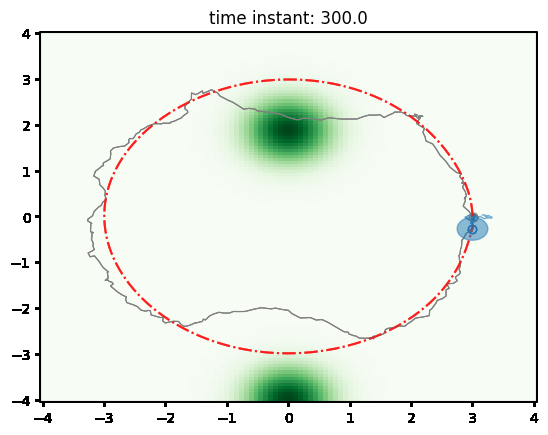

Simulation time: 302  ---  |x-xbar|: 0.370915
Simulation time: 304  ---  |x-xbar|: 0.293259
Simulation time: 306  ---  |x-xbar|: 0.211106
Simulation time: 308  ---  |x-xbar|: 0.127165


In [49]:
Horizon = 20
timeInstantOpt = 2
epochs_RH = 150
n_traj_ol = 3
# generating same initial phase for the obstacles
phaseCL1 = torch.randn(1).item()
phaseCL2 = torch.randn(1).item()

# # # # # # # # Train # # # # # # # #
# Train the controller using the NeurSLS algorithm
print("------------ Begin training ------------")
print("Problem: RH neurSLS -- t_end: %i" % t_end + " -- lr: %.2e" % learning_rate +
      " -- epochs: %i" % epochs_RH + " -- n_traj: %i" % n_traj_ol + " -- std_ini: %.2f" % std_ini)
print(" -- alpha_u: %.1f" % alpha_u + " -- alpha_ca: %i" % alpha_ca + " -- alpha_obst: %.1e" % alpha_obst)
print("REN info -- n_xi: %i" % n_xi + " -- l: %i" % l)
print("RH info -- Horizon: %i" % Horizon)
print("--------- --------- ---------  ---------")


# Data for log
x_log = torch.zeros(sim_time+1, syst.n)
u_log = torch.zeros(sim_time, syst.m)
w_in = torch.randn(sim_time + 1, syst.n)
gainM = gamma_bar
x = x0
x_error = x - x0t  # start 
x_log[0, :] = x0.detach()
xi = torch.zeros(ctl.n)
w_REN = x_error
u, xi = ctl(0, w_REN, xi)
usys = gainM * u
# Loop for the simulation
loss_trained = np.zeros(sim_time+1)
tOL = 0
# Compute the next state and control input using the system and controller models
dynamic_obstacle = DynamicObstacle(amplitude=Aobs, frequency=fobs, init_pos = init_pos1, phase=phaseCL1, noise_level=w_obs, device=device)
dynamic_obstacle2 = DynamicObstacle(amplitude=Aobs, frequency=-fobs, init_pos = init_pos2, phase=phaseCL2, noise_level=w_obs, device=device)
r = 2*(r_log_pre[:,:].detach())
xiOR = ctl.x0
ctlRH = None

for tsim in range(sim_time):
    obstacle_pos1 = dynamic_obstacle.update_position(dt=Ts, velocity_noise = velocity_noiseCL[tsim])# closed loop noise on the obstacle
    obstacle_pos2 = dynamic_obstacle2.update_position(dt=Ts, velocity_noise = velocity_noiseCL[tsim])# closed loop noise on the obstacle
    obstacle_pos = torch.cat((obstacle_pos1,obstacle_pos2),dim=0)
    u_log[tsim, :] = usys.detach()
    w_sys = w_inCL[tsim,:] 
    x_error = syst.forward(tsim, x_error, usys, w_sys)
    x = x_error+torch.tensor(ref_traj.get_reference(tsim))
    x_log[tsim, :] = x.detach()
    if (tsim % timeInstantOpt == 0) :# and (tsim>0)):
        eps = torch.norm(x_error)
        gainMt = (r[tsim] / (gainF * eps.detach()))-1
        if (gainMt.item() >0):
            gainM = gainMt
            print("Simulation time: %i  ---  |x-xbar|: %1f" % (tsim, torch.norm(x_error)))
            # Loop over the specified number of epochs
            x_errort0 = x_error.detach()
            if ctlRH is None:
                ctlRH = RenG(syst.n, syst.m, n_xi, l, bias=False, mode="l2stable", gamma=1)
                ctlRH.load_state_dict(torch.load("trained_models/offline_obstacles_ctl.pt", weights_only=False))
                ctlRH.set_param()
                state_dict = ctlRH.state_dict()
                state_dict['ctlRH.x0'] = xiOR.detach()   
            else:
                state_dict = ctlRH.state_dict()
                state_dict['ctlRH.x0'] = xi.detach()
            optimizer = torch.optim.Adam([{'params': ctlRH.parameters()}], lr=learning_rate)
            # add if you want an initial deeper training
            if tsim == 0:
                epochs_tr = 3*epochs_RH
            else:
                epochs_tr = epochs_RH
            for epoch in range(epochs_tr):
                # Reset the gradients of the optimizer
                if epoch > 0:
                    del xt,x_errort,w_int,xit,w_RENt,ut,usyst,loss
                # Reset the gradients of the optimizer
                optimizer.zero_grad()
                # Initialize the loss and its components for this epoch
                loss_x, loss_u, loss_obst = 0, 0, 0
                # Loop over the specified number of trajectories
                xt_log = torch.zeros(Horizon, syst.n, n_traj_ol)
                ut_log = torch.zeros(Horizon, syst.m, n_traj_ol)
                for kk in range(n_traj_ol):
                    obstacle_pos1t_tot = dynamic_obstacle.predict_future_positions(Ts,Horizon)
                    obstacle_pos2t_tot = dynamic_obstacle2.predict_future_positions(Ts,Horizon)
                    x_errort = x_errort0#+devx0  # start 
                    w_int = w_std * torch.randn((sim_time+Horizon + 1, syst.n))
                    xit = xi.detach()
                    w_RENt = x_errort
                    ut, xit = ctlRH(0, w_RENt, xit)
                    usyst = gainM * ut
                    for t in range(Horizon):
                        obstacle_pos1t = obstacle_pos1t_tot[:,:,t].squeeze()
                        obstacle_pos2t = obstacle_pos2t_tot[:,:,t].squeeze()
                        obstacle_post = torch.cat((obstacle_pos1t,obstacle_pos2t),dim=0)
                        xt = x_errort+torch.tensor(ref_traj.get_reference(t+tsim))
                        # Compute the next state and control input using the system and controller models
                        xt_log[t, :,kk] = xt.detach()
                        ut_log[t, :,kk] = usyst.detach()
                        w_syst = w_int[tsim+t,:]
                        x_errort = syst.forward(t+tsim, x_errort, usyst, w_syst)
                        w_RENt = w_syst
                        ut, xit = ctlRH(t+tsim, w_RENt, xit)
                        usyst = gainM * ut
                        # Compute the loss and its components for this time step
                        loss_x =  loss_x + f_loss_states_tracking(t+tsim, xt, syst,x_traj_opt_np, Q)
                        loss_u = loss_u + alpha_u * f_loss_u(t+tsim, usyst)
                        if alpha_obst != 0:
                            loss_obst = loss_obst + alpha_obst * f_loss_obst_dyn_tracking(xt,obstacle_post)

                # Compute the total loss for this epoch and log its components
                loss = loss_x + loss_u + loss_obst

                # Backpropagate the loss through the controller model and update its parameters
                loss.backward(retain_graph=True)
                optimizer.step()
                ctlRH.set_param()

            if (tsim%50 == 0):# Plot and log the closed-loop trajectories with the trained controller
                plot_trajectories_tracking_dyn_obs(xt_log, x_traj_opt_np, syst.n_agents,obstacle_pos, text="time instant: %.1f" % tsim , save=False , T=Horizon, obst=alpha_obst, x_=x_log, T_=tsim)

            w_REN = w_sys
            xi = torch.zeros(ctl.n)
            u, xi = ctlRH(0, w_REN, xi)
            usys = gainM * u
        else:
            warnings.warn("gain NEGATIVO.", UserWarning)
            print('time %i' % tsim)
            w_REN = w_sys
            u, xi = ctlRH(tsim, w_REN, xi)
            usys = gainM * u
            

    else:
        w_REN = w_sys
        u, xi = ctlRH(tsim, w_REN, xi)
        usys = gainM * u
    loss_trained[tsim+1] = loss_trained[tsim]+f_loss_states_tracking(tsim, x, syst,x_traj_opt_np, Q)+alpha_u * f_loss_u(tsim, usys)+ alpha_obst * f_loss_obst_dyn_tracking(x,obstacle_pos)

------- Print trained closed-loop trajectories --------


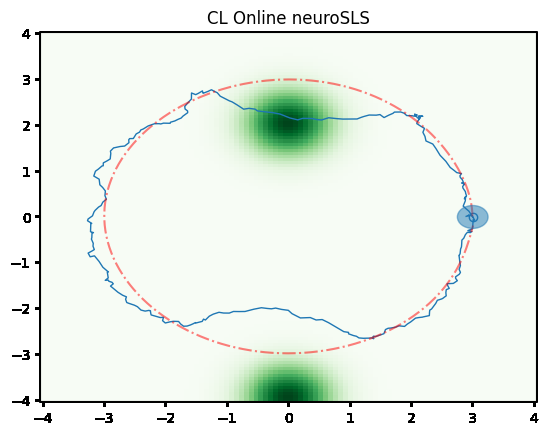

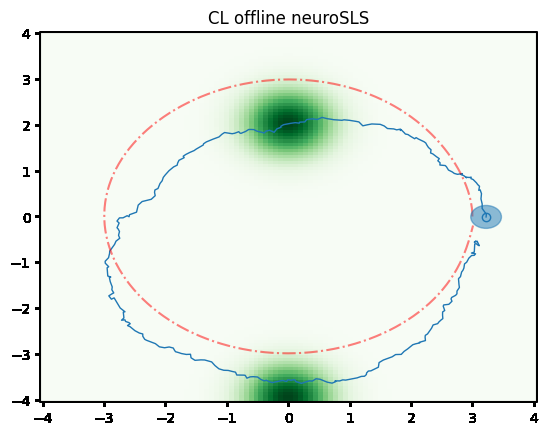

Cumulative loss online 245463.018472 
Cumulative loss offline 1409289.264791 


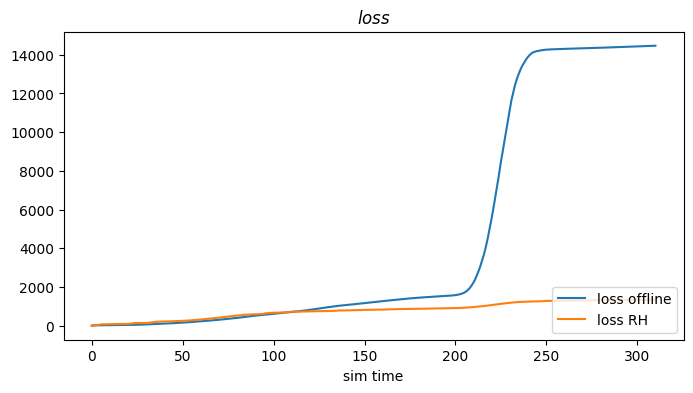

In [50]:
# Plot and log the closed-loop trajectories with pre-trained network
loss_log_pre = np.zeros(sim_time+1)

dynamic_obstacle = DynamicObstacle(amplitude=Aobs, frequency=fobs, init_pos = init_pos1, phase=phaseCL1, noise_level=w_obs, device=device)
dynamic_obstacle2 = DynamicObstacle(amplitude=Aobs, frequency=-fobs, init_pos = init_pos2, phase=phaseCL2, noise_level=w_obs, device=device)
devx0 = std_ini * torch.randn(x0.shape)
x = x0 + devx0
x_error = x - x0t  # start 
xi = torch.zeros(ctl.n)
w_REN = x_error
u, xi = ctl(0, w_REN, xi)
usys = amplifier(u)
with torch.no_grad():
    loss = 0
    for t in range(t_end):
        obstacle_pos1 = dynamic_obstacle.update_position(dt=Ts, velocity_noise = velocity_noiseCL[t])# closed loop noise on the obstacle
        obstacle_pos2 = dynamic_obstacle2.update_position(dt=Ts, velocity_noise = velocity_noiseCL[t])# closed loop noise on the obstacle
        obstacle_pos = torch.cat((obstacle_pos1,obstacle_pos2),dim=0)
        x = x_error + torch.tensor(ref_traj.get_reference(t), dtype=torch.float32, device=device)
        x_log_pre[t, :,-1] = x
        u_log_pre[t, :,-1] = usys.detach()
        w_syst = w_inCL[t,:]   # CL loop noise   
        x_error = syst.forward(t, x_error, usys, w_syst)
        w_REN = w_syst
        u, xi = ctl(t, w_REN, xi)
        usys = amplifier(u)
        loss_x =  f_loss_states_tracking(t, x, syst,x_traj_opt_np, Q)
        loss_u = alpha_u * f_loss_u(t, usys)
        if alpha_obst != 0:
            loss_obst =  alpha_obst * f_loss_obst_dyn_tracking(x,obstacle_pos)
        loss = loss_x + loss_u + loss_obst
        loss_log_pre[t+1] = loss_log_pre[t] + loss



print("------- Print trained closed-loop trajectories --------")

plot_trajectories_tracking_dyn_obs(x_log[:-1,:], x_traj_opt_np, syst.n_agents,obstacle_pos, text="CL Online neuroSLS",save=False, filename="trajectories_RH" , T=sim_time, obst=alpha_obst)
plot_trajectories_tracking_dyn_obs(x_log_pre[:,:,-1], x_traj_opt_np, syst.n_agents,obstacle_pos, text="CL offline neuroSLS",save=False, filename="trajectories_RH" , T=sim_time, obst=alpha_obst)

time = torch.linspace(0, sim_time, sim_time)
plt.figure(figsize=(4 * 2, 4))
plt.plot(time, loss_log_pre[:-1])
plt.plot(time, loss_trained[:-1])
plt.xlabel(r'sim time')
plt.title(r'$loss$')
plt.legend(["loss offline", "loss RH"], loc="lower right")

total_cost_pretrained = loss_log_pre[:-1].sum()
total_cost_trained = loss_trained[:-1].sum()
print(f"Cumulative loss online {total_cost_trained:.6f} ")
print(f"Cumulative loss offline {total_cost_pretrained.item():.6f} ")